# Problem Statement

Build a **sentiment-based product recommendation system** for '*Ebuss*', an e-commerce company, to improve the recommendations given to the users given their past reviews and ratings.

Perform the following:
 - **Data sourcing and sentiment analysis**
    - Exploratory data analysis
    - Data cleaning
    - Text preprocessing
    - Feature extraction
    - Training a text classification model (select the best model)
       1. Logistic regression
       2. Random forest
       3. XGBoost
       4. Naive Bayes
 - **Building a recommendation system**  
    - Select the one that is best suited: 
        1. User-based recommendation system
        2. Item-based recommendation system
    - Determine the top 20 products that a user is most likely to purchase based on the ratings
 - **Improving the recommendations using the sentiment analysis model**
    - Use both the recommendation system and the sentiment analysis model to further filter out the top 5 products (based on both ratings and sentiments).
 - **Deploying the end-to-end project with a user interface**
    - Use Flask framework and Heroku:
        1. Enter any of the existing username.
        2. Click [Submit] to see the top 5 recommended products for that user.

# Importing libraries

In [1]:
import json 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve
from scikitplot.metrics import plot_roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

import re, nltk, spacy, string
import spacy
import en_core_web_sm
# nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

from sklearn.preprocessing import MinMaxScaler
from numpy import *

# Import pickle
import pickle

from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from pprint import pprint

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dipin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dipin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data sourcing and sentiment analysis

## Exploratory data analysis

In [2]:
df = pd.read_csv("sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
df.shape

(30000, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

## Data Cleaning

In [5]:
df.isna().mean().round(4).mul(100).sort_values(ascending=False)

reviews_userProvince    99.43
reviews_userCity        93.57
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_title            0.63
manufacturer             0.47
reviews_username         0.21
reviews_date             0.15
id                       0.00
brand                    0.00
categories               0.00
name                     0.00
reviews_rating           0.00
reviews_text             0.00
user_sentiment           0.00
dtype: float64

Observations:

- As reviews_userProvince and reviews_userCity have over 93% missing values, let's remove these columns (as imputation could lead to high noise in the data).
- Also, reviews_didPurchase column has over 46% NULL values. As this doesn't help in calulating the sentiment, let's drop this column too.

In [6]:
df_clean = df.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'])
df_clean.shape

(30000, 12)

Change the type of reviews_date column from object to date

In [7]:
df_clean['reviews_date'] = pd.to_datetime(df_clean['reviews_date'], errors='coerce')

In [8]:
# Check for duplicate records
df_clean[df_clean.duplicated()]
df_clean.drop_duplicates()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23 00:00:00+00:00,True,5,I got this conditioner with Influenster to try...,Softness!!,laurasnchz,Positive
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27 00:00:00+00:00,True,5,"I love it , I received this for review purpose...",I love it,scarlepadilla,Positive
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21 00:00:00+00:00,True,5,First of all I love the smell of this product....,Hair is so smooth after use,liviasuexo,Positive
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11 00:00:00+00:00,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,ktreed95,Positive


### Handle Missing Values

#### reviews_doRecommend column

In [9]:
df_clean.reviews_doRecommend.value_counts(normalize=True)

reviews_doRecommend
True     0.943493
False    0.056507
Name: proportion, dtype: float64

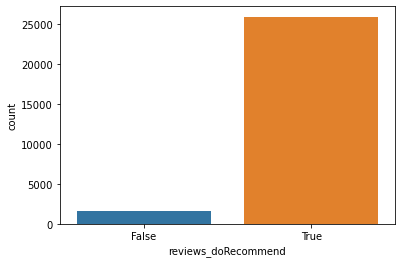

In [10]:
sns.countplot(x = 'reviews_doRecommend', data = df_clean)
plt.show()

Observation:
- 'reviews_doRecommend' has more than 94% of the values as True. 
- This column has a very low variance. Let's drop it as it does not help in predicting the target variable.

In [11]:
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)

#### reviews_title column

reviews_title column has only 0.63% of missing values. As this is a very small percentage of records, let's remove only those records with null values.

In [12]:
df_clean = df_clean[~df_clean.reviews_title.isna()]

#### reviews_username column

reviews_username column has only 0.2% of missing values. So let's remove only those records with null values.

In [13]:
df_clean = df_clean[~df_clean.reviews_username.isna()]

#### user_sentiment column

In [14]:
df_clean[df_clean.user_sentiment.isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07 00:00:00+00:00,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


Only one record has a missing value in 'user_sentiment' column.

As the review title reveals a positive sentiment, let's hardcode the value of 'user_sentiment' for this record to 'Positive'.

In [15]:
df_clean.user_sentiment.fillna('Positive', inplace=True)

In [16]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df_clean['user_sentiment'] = df_clean['user_sentiment'].map({'Positive':1,'Negative':0})

### Univariate Analysis

#### reviews_rating column

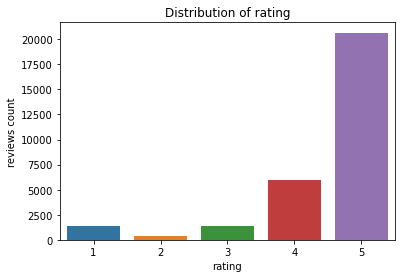

In [17]:
sns.countplot(data = df_clean, x = 'reviews_rating').set(title="Distribution of rating", xlabel="rating", ylabel="reviews count")
plt.show()

Observation:
- Rating of 5 has the majority count of all. This may lead to data imbalance.

#### Top 5 Brands with positive reviews

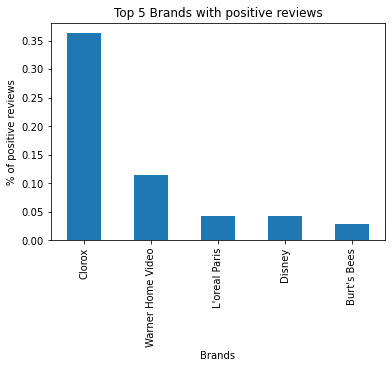

In [18]:
df_clean[df_clean.user_sentiment == 1].brand.value_counts(
    normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with positive reviews")
plt.xlabel("Brands")
plt.ylabel("% of positive reviews")
plt.show()

In [19]:
df_clean.brand.value_counts(normalize=True).head(5)

brand
Clorox               0.355116
Warner Home Video    0.111739
Disney               0.040238
L'oreal Paris        0.039868
FOX                  0.029817
Name: proportion, dtype: float64

Observation:
- Clorox is the brand with the most positive reviews (more than 35% of the positive reviews were for Clorox).
- Of all the brands in our dataset Clorox occupies more than 35% share which explains why Colorox has most of the top positive reviews.

#### Top 5 Brands with negative reviews

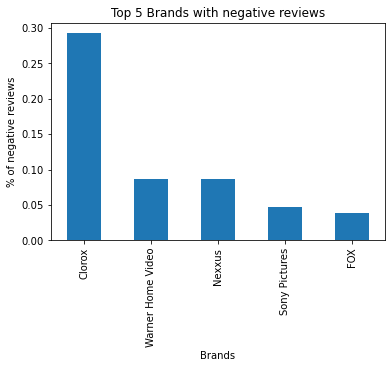

In [20]:
df_clean[df_clean.user_sentiment == 0].brand.value_counts(
    normalize=True, ascending=False).head(5).plot(kind='bar')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("% of negative reviews")
plt.show()

Observation:
- Clorox is the brand with the highest negative reviews (more than 30% were for Clorox).

#### Reviews by Year

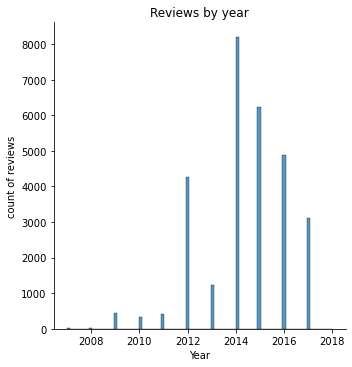

In [21]:
# Creating a distribution plot based on reviews year
sns.displot(data=df_clean, x=df_clean.reviews_date.dt.year).set(
    title="Reviews by year", xlabel="Year", ylabel="count of reviews")
plt.show()

Observation:
- Of all the years, year 2014 contains the most number of reviews.

#### Sentiment by Ratings

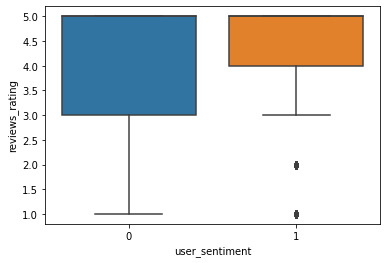

In [22]:
sns.boxplot(data=df_clean, x='user_sentiment', y='reviews_rating')
plt.show()

In [23]:
df_clean[(df_clean.user_sentiment == 0) & (
    df_clean.reviews_rating >= 4)].groupby(['reviews_rating']).count().user_sentiment

reviews_rating
4     548
5    1848
Name: user_sentiment, dtype: int64

Observation:
- Over 2,000 records with 4 & 5 ratings show Negative sentiment which might indicate that these ratings were provided much earlier before using the product.

In [24]:
df_clean.shape

(29748, 11)

## Text Pre-processing

#### Convert all the text columns to string

In [25]:
# Convert all the text columns to string
df_clean['brand'] = df_clean['brand'].astype(str)
df_clean['categories'] = df_clean['categories'].astype(str)
df_clean['manufacturer'] = df_clean['manufacturer'].astype(str)
df_clean['name'] = df_clean['name'].astype(str)
df_clean['reviews_text'] = df_clean['reviews_text'].astype(str)
df_clean['reviews_title'] = df_clean['reviews_title'].astype(str)
df_clean['reviews_username'] = df_clean['reviews_username'].astype(str)

In [26]:
df_prep = df_clean.copy()

Drop columns, 'categories', 'manufacturer', 'reviews_date' as that do not add any value to predicting the sentiment

In [27]:
df_prep.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)

#### Combine reviews_title and reviews_text as they both reflect the same sentiment

In [28]:
df_prep['reviews_combined'] = df_prep['reviews_title'] + " " + df_prep['reviews_text']
df_prep.drop(columns=[ 'reviews_title', 'reviews_text'], inplace=True)

In [29]:
df_prep.sample(1)

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
18084,AVpfD9xTLJeJML431ig2,FOX,There's Something About Mary (dvd),4,slouchycowman,1,There's Something About Mary is very funny Thi...


In [30]:
# Create dataframe for Sentiment analysis with only these required columns
df_sent = df_prep[['id','name','reviews_combined', 'user_sentiment']]
df_sent.sample(5)

,id,name,reviews_combined,user_sentiment
1601,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,good movie if you like Johnny depp vampire & w...,0
9991,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,Easily accessible My mother is wheelchair boun...,1
28259,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,Great movie Disney does it again. A great stor...,1
24315,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,Entertaining Glad they did a good job in makin...,1
2498,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),Funny Made us laugh quite a lot... I'm always ...,1


In [31]:
df_sent.shape

(29748, 4)

### Basic Pre-processing

Do the following operations:
- Make the text lowercase
- Remove text in square brackets
- Remove punctuation
- Remove words containing numbers

In [32]:
# Function to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove text in square brackets
    text = re.sub(r'\[\w+\]', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) # replace any non-word char with empty string
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text).strip()
    return " ".join(text.split()) # Remove all whitespace characters (space, tab, newline, return, formfeed)

In [33]:
df_sent['reviews_cleaned'] = df_sent['reviews_combined'].apply(lambda x: clean_text(x))

In [34]:
df_sent.sample(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
22935,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,we did not care for the movie at it was to lon...,1,we did not care for the movie at it was to lon...
15721,AVpf5Z1zLJeJML43FpB-,"Lysol Concentrate Deodorizing Cleaner, Origina...",Love it! I absolutely love this product! When ...,1,love it i absolutely love this product when i ...


### Remove Stopwords

In [35]:
# Function to remove the stopwords
def remove_stopwords(sent):
#     sent = sent.lower()  # convert text to lowercase
    words = word_tokenize(sent)  # split sentences into words
    sent = " ".join(
        [word for word in words if word not in stopwords.words('english')]) #remove stopwords
    return sent

In [36]:
df_sent['reviews_cleaned'] = df_sent['reviews_cleaned'].apply(lambda x: remove_stopwords(x))

In [37]:
df_sent.sample(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
25972,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,nice Love this movie great hope for part 2 buy...,1,nice love movie great hope part buy
4437,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight B...,Great Vacuum for the price We needed a vacuum ...,1,great vacuum price needed vacuum cleaner bags ...


### Lemmatize the texts

In [38]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [39]:
df_sent['reviews_lemmatized'] = df_sent['reviews_cleaned'].apply(lambda x: lemmatize_text(x))

In [40]:
df_sent.sample(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned,reviews_lemmatized
14761,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,crazy Love it I recommend them to disinfect do...,1,crazy love recommend disinfect door handles co...,crazy love recommend disinfect door handle cou...
23073,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,Bring Home Godzilla Bring Home Godzilla. Great...,1,bring home godzilla bring home godzilla great ...,bring home godzilla bring home godzilla great ...


In [41]:
# Create a dataframe that will have only the 'id','name','reviews_lemmatized', 'user_sentiment' columns
df_sent = df_sent[['id','name','reviews_lemmatized', 'user_sentiment']]

In [42]:
df_sent.sample(2)

,id,name,reviews_lemmatized,user_sentiment
29907,AVpfW8y_LJeJML437ySW,L'or233al Paris Elvive Extraordinary Clay Reba...,great stuff recieve free testing purpose influ...,1
23774,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,godzilla iteration famous lizard leap bound pr...,1


In [43]:
df_sent.shape

(29748, 4)

#### Save this cleaned & text pre-processed dataframe

In [44]:
# Save the cleaned df_sent dataframe as clean_data
pickle.dump(df_sent, open("./models/clean_data.pkl","wb"))

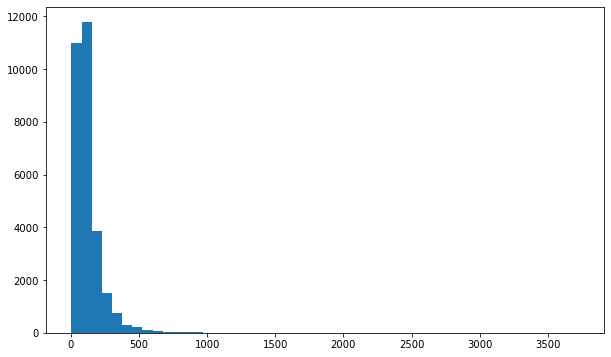

In [45]:
# Visualise the data according to the 'Review Text' character length
plt.figure(figsize=(10,6))
reviews_lens = [len(d) for d in df_sent.reviews_lemmatized]
plt.hist(reviews_lens, bins = 50)
plt.show()

Observation:
- Most of the reviews are under 500 characters.

#### Visualize the top 30 words

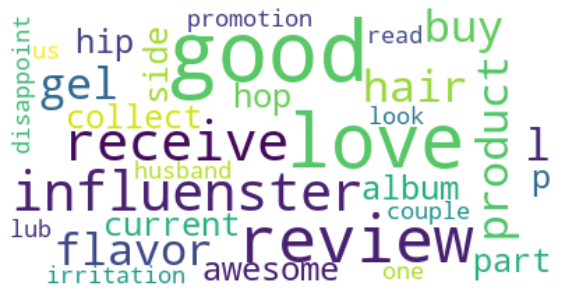

In [46]:
# Use a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sent['reviews_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Most common words

In [47]:
def getMostCommonWords(reviews, n_most_common):
    # Flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in
                         review.lower().split()]
    # Remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if
                                 char not in string.punctuation) for
                         review in flattened_reviews]
    # Remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [48]:
pos_reviews = df_sent[df_sent['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_lemmatized'],10)

[('great', 14432),
 ('love', 12447),
 ('use', 12072),
 ('product', 11325),
 ('movie', 10050),
 ('good', 8663),
 ('review', 8579),
 ('part', 8342),
 ('collect', 7967),
 ('promotion', 7945)]

In [49]:
neg_reviews = df_sent[df_sent['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_lemmatized'],10)

[('use', 1583),
 ('product', 1335),
 ('review', 896),
 ('part', 841),
 ('not', 833),
 ('movie', 832),
 ('collect', 800),
 ('promotion', 800),
 ('wipe', 721),
 ('like', 705)]

#### Top N-grams

In [50]:
# function to collect the n-gram frequency of words
def get_top_n_ngram(corpus, n_gram_range, n=None):
    vec = CountVectorizer(ngram_range=(
        n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    for word, idx in vec.vocabulary_.items():
        break
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    # print("-31",words_freq)
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [51]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_lemmatized'], 2, 10)
pd.DataFrame(common_words)

,0,1
0,review collect,7941
1,collect promotion,7941
2,clorox wipe,2582
3,great product,1899
4,great movie,1705
5,easy use,1548
6,love clorox,1174
7,love product,1132
8,good movie,1046
9,use clorox,952


In [52]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_lemmatized'], 2, 10)
pd.DataFrame(common_words)

,0,1
0,review collect,799
1,collect promotion,799
2,clorox wipe,260
3,use product,176
4,old formula,174
5,new formula,163
6,use clorox,154
7,bring old,116
8,great product,111
9,resident evil,103


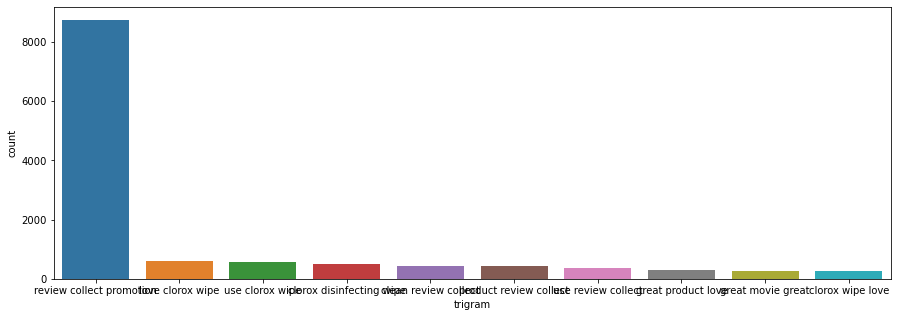

In [53]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean). 
common_words = get_top_n_ngram(df_sent.reviews_lemmatized, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[15,5])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.show()

### Feature Extraction

Perform the following operations:
1. Feature Extraction using TF-IDF
2. Handle class imbalance
3. Perform train, test split

#### TF-IDF Feature Extraction

Feature Extraction using TF-IDF to convert raw text to a matrix of TF-IDF features.  

**max_df** is used for removing terms that appear too frequently (also known as "corpus-specific stop words"). max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints".  

**min_df** is used for removing terms that appear not too often. min_df = 5 means "ignore terms that appear in less than 5 complaints".  

In [54]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [55]:
X = tfidf.fit_transform(df_sent['reviews_lemmatized'])
y= df_sent['user_sentiment']

In [56]:
# Save the the tfidf vectorizer model
pickle.dump(tfidf, open("./models/tfidf.pkl","wb"))

#### Split train-test

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [58]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22311, 15747) (22311,)
Test shapes: (7437, 15747) (7437,)


#### Class Imbalance

In [59]:
# Look for class imbalance in the dataset
df_sent['user_sentiment'].value_counts(normalize=True)

user_sentiment
1    0.887892
0    0.112108
Name: proportion, dtype: float64

Observation:
- Positive sentiments make upto 89% whereas Negative sentiments count for just 11%.
- To handle this imbalance, let's use **SMOTE** (Synthetic Minority Oversampling Technique), an oversampling method that generates synthetic samples for the minority class.

In [60]:
counter = Counter(y_train)
print("Before:", counter)

#oversampling using SMOTE
smote = SMOTE(random_state=100)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After using SMOTE:", counter)

Before: Counter({1: 19786, 0: 2525})
After using SMOTE: Counter({1: 19786, 0: 19786})


Now that we have a well balanced dataset, let's proceed with model building and prediction.

## Training a text classification model

Select one of these classification models based on their performance -   
1. Logistic regression  
2. Random forest
3. XGBoost
4. Naive Bayes

In [61]:
# Function to display scores
def evaluate_model(classifier, X_test, y_test):

    # Calculate Predicted value
    y_pred = classifier.predict(X_test)

    # Create confusion matrix
    conf_m = confusion_matrix(y_test, y_pred)

    print("Visualize the Confusion Matrix with a Heatmap")
    print("-"*45)
    # Visualize Confusion Matrix with heatmap
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                     annot=True,
                     cbar=False,
                     cmap="RdYlGn", fmt='0.1f')
    plt.xlabel("Actual label")
    plt.ylabel("Predicted label")
    plt.show()

    # Calculate the values of True Positives, True Negatives, False Positivies and False Negatives
    TP = conf_m[1][1]
    TN = conf_m[0][0]
    FP = conf_m[0][1]
    FN = conf_m[1][0]

    # Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = round(accuracy, 2)

    # Calculate Recall
    recall = (TP / float(TP + FN))
    recall = round(recall, 2)

    # Calculate Precision
    precision = (TP / float(TP + FP))
    precision = round(precision, 2)

    # Calculate F_1 score
    F1_score = 2 * ((precision * recall) /
                    (precision + recall))
    F1_score = round(F1_score, 2)

    # Returning evaluation results for comparison later
    evaluation_metrics = []
    evaluation_metrics.append(accuracy)
    evaluation_metrics.append(recall)
    evaluation_metrics.append(precision)
    evaluation_metrics.append(F1_score)

    return evaluation_metrics

### Logistic Regression

#### Base Model

In [62]:
logreg = LogisticRegression(random_state=100, solver='liblinear').fit(X_train_sm, y_train_sm)

Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


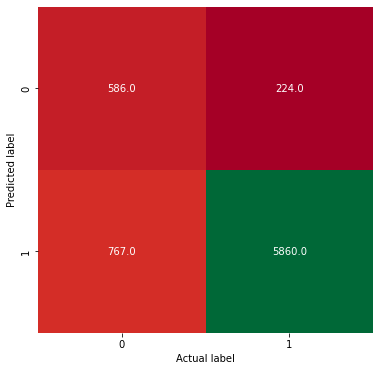

In [63]:
# Get the score of the base model
logreg_metrics = evaluate_model(logreg, X_test, y_test)

In [64]:
# Print the scores of the base model as reference
df_lrb_metrics = pd.DataFrame({'Metrics': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
                              'Logistic Regression Base Model': logreg_metrics})
df_lrb_metrics

,Metrics,Logistic Regression Base Model
0,Accuracy,0.87
1,Recall,0.88
2,Precision,0.96
3,F1 Score,0.92


Observation:
- The Base model of Logistic Regression shows good performance (Accuracy & F1 Score). Let's see if we can further improve the scores after hyperparameter tuning.

#### Hyper-parameter Tuning

In [65]:
# Different solvers
solvers = ['newton-cg', 'lbfgs', 'liblinear']
# Regularization (penalty)
penalty = ['l2']
# C parameter controls the penality strength
c_values = [100, 10, 1.0, 0.1, 0.01]

# Define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logreg_hpt = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_result = logreg_hpt.fit(X_train_sm, y_train_sm)

Observation:
- I can choose 'accuracy' or 'f1 score' here as this is a balanced dataset. I'm going to stick with **'f1 score'** to determine the better performing model.

In [66]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.960198 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


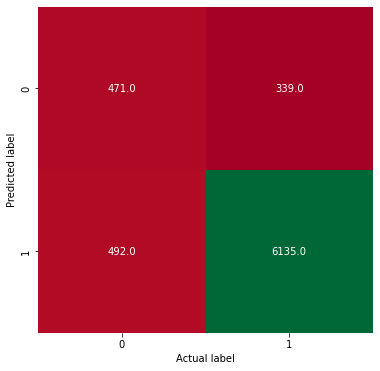

In [67]:
# Get the scores of the tuned model
logreg_tuned_metrics = evaluate_model(logreg_hpt, X_test, y_test)

In [68]:
# Printing the scores of the base model as reference
df_lr_b_vs_ht_metrics = pd.DataFrame({'Metrics': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
                              'LR Base Model': logreg_metrics, 'LR Tuned Model': logreg_tuned_metrics})
df_lr_b_vs_ht_metrics

,Metrics,LR Base Model,LR Tuned Model
0,Accuracy,0.87,0.89
1,Recall,0.88,0.93
2,Precision,0.96,0.95
3,F1 Score,0.92,0.94


Observation:
- The **hypertuned Logistic Regression** Model performs better (both Accuracy & F1 Score habing higher values) than the base model.

#### Save the Models

In [69]:
lr_base_model = pickle.dump(logreg, open('./pickle/lr_base_model.pkl', 'wb'))
lr_tuned_model = pickle.dump(logreg_hpt, open('./pickle/lr_tuned_model.pkl', 'wb'))

### Random Forest

#### Base Model

In [70]:
rf = RandomForestClassifier(random_state=100).fit(X_train_sm, y_train_sm)

Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


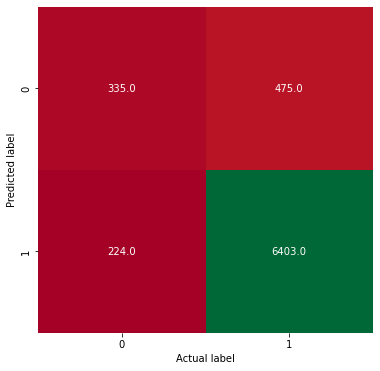

In [71]:
# Get the score of the base model
rf_metrics = evaluate_model(rf, X_test, y_test)

In [72]:
# Print the scores of the base model
df_rfb_metrics = pd.DataFrame({'Metrics': [
                              'Accuracy', 'Recall', 'Precision', 'F1 Score'], 'RF Base Model': rf_metrics})
df_rfb_metrics

,Metrics,RF Base Model
0,Accuracy,0.91
1,Recall,0.97
2,Precision,0.93
3,F1 Score,0.95


Observation:
- The base model of Random Forest shows really good performance (Accuracy & F1 Score). Let's see if I can further improve the scores after hyperparameter tuning.

#### Hyper-parameter Tuning

The most important parameter is the number of random features to sample at each split point (max_features). Another important parameter for random forest is the number of trees (n_estimators).

In [73]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

# Define grid search
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                            param_distributions=rf_grid,
                            cv=5,
                            verbose=True,
                            n_jobs=-1,
                            scoring='f1')
# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'min_samples_split': array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390,
       405, 420, 435, 450, 465, 480, 495]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   scoring='f1', verbose=True)

In [74]:
# summarize results
print("Best: %f using %s" % (rf_hpt.best_score_, rf_hpt.best_params_))

Best: 0.860962 using {'n_estimators': 860, 'min_samples_split': 360, 'min_samples_leaf': 10, 'max_depth': 40}


Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


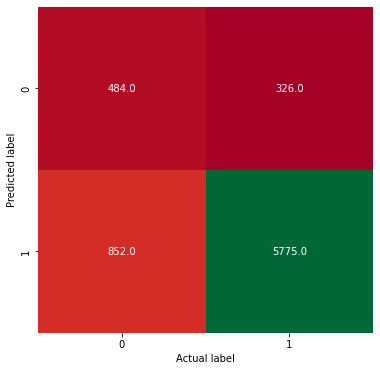

In [75]:
# Get the scores of the tuned model
rf_tuned_metrics = evaluate_model(rf_hpt, X_test, y_test)

In [76]:
# Printing the scores of the base model as reference
df_rf_b_vs_ht_metrics = pd.DataFrame({'Metrics': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
                              'RF Base Model': rf_metrics, 'RF Tuned Model': rf_tuned_metrics})
df_rf_b_vs_ht_metrics

,Metrics,RF Base Model,RF Tuned Model
0,Accuracy,0.91,0.84
1,Recall,0.97,0.87
2,Precision,0.93,0.95
3,F1 Score,0.95,0.91


Observation:
- The **base model of Random Forest** performs better (improved Accuracy & f1 score) than its hypertuned counterpart.

#### Save the Models

As the pickle file of the random forest model is too large (96MB), I save it in a compressed pickle format.

In [78]:
# rf_base_model = pickle.dump(srf, open('./pickle/rf_base_model.pkl', 'wb'))
# rf_tuned_model = pickle.dump(rf_hpt, open('./pickle/rf_tuned_model.pkl', 'wb'))
import bz2
with bz2.BZ2File('./pickle/rf_base_model.pbz2', 'w') as f:
    pickle.dump(rf, f)
with bz2.BZ2File('./pickle/rf_tuned_model.pbz2', 'w') as f:
    pickle.dump(rf_hpt, f)

### XGBoost Classifier

#### Base Model

In [79]:
# xg = xgb.XGBClassifier(random_state=101).fit(X_train_sm, y_train_sm)
#ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Negative' 'Positive']

XGBoost requires that the output variables to be numeric. I can convert the string values to integer values using the `LabelEncoder`

In [80]:
# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train_sm)
y_train_sm_enc = label_encoder.transform(y_train_sm)
y_test_enc = label_encoder.transform(y_test)

In [81]:
xg = xgb.XGBClassifier(random_state=101).fit(X_train_sm, y_train_sm_enc)

Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


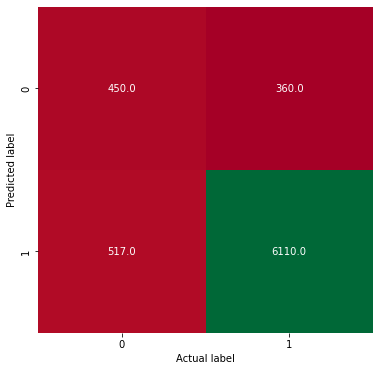

In [82]:
# Getting the score of the base model
xg_metrics = evaluate_model(xg, X_test, y_test_enc)

In [83]:
# Print the scores of the base model
df_xgb_metrics = pd.DataFrame({'Metrics': [
                              'Accuracy', 'Recall', 'Precision', 'F1 Score'], 'XG Base Model': xg_metrics})
df_xgb_metrics

,Metrics,XG Base Model
0,Accuracy,0.88
1,Recall,0.92
2,Precision,0.94
3,F1 Score,0.93


#### Hyper-parameter Tuning

In [84]:
# Using a GridSearchCV
xg_grid = {'max_depth': [3, 6, 10],
          'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [100, 500, 1000],
          'colsample_bytree': [0.3, 0.7]}
xg_hpt = GridSearchCV(estimator=xg,
                      param_grid=xg_grid, 
                      scoring='f1',
                      verbose=1)

In [85]:
# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_sm_enc)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=101, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='f1', verbose=1)

In [86]:
# summarize results
print("Best: %f using %s" % (xg_hpt.best_score_, xg_hpt.best_params_))

Best: 0.945410 using {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}


Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


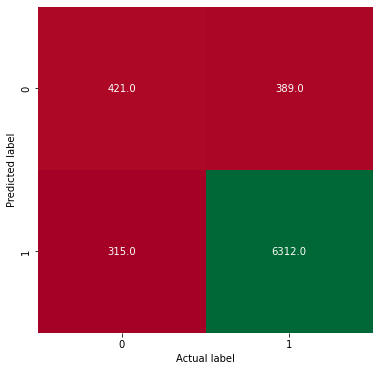

In [87]:
# Get the scores of the tuned model
xg_tuned_metrics = evaluate_model(xg_hpt, X_test, y_test_enc)

In [88]:
# Printing the scores of the base model as reference
df_xg_b_vs_ht_metrics = pd.DataFrame({'Metrics': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xg_tuned_metrics})
df_xg_b_vs_ht_metrics

,Metrics,XG Base Model,XG Tuned Model
0,Accuracy,0.88,0.91
1,Recall,0.92,0.95
2,Precision,0.94,0.94
3,F1 Score,0.93,0.94


Observation:
- The **hypertuned model of XGBoost** outshines (higher accuracy & f1 score) its base counterpart.

#### Save the Models

In [89]:
xg_base_model = pickle.dump(xg, open('./pickle/xg_base_model.pkl', 'wb'))
xg_tuned_model = pickle.dump(xg_hpt, open('./pickle/xg_tuned_model.pkl', 'wb'))

### Naive Bayes

#### Base Model

In [90]:
from sklearn.naive_bayes import MultinomialNB
# instantiate NB class
mnb=MultinomialNB()
# fitting the model on training data
mnb.fit(X_train_sm, y_train_sm)

MultinomialNB()

Visualize the Confusion Matrix with a Heatmap
---------------------------------------------


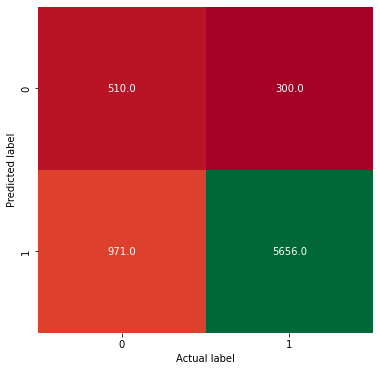

In [91]:
mnb_metrics = evaluate_model(mnb, X_test, y_test)

In [92]:
# Print the scores of the base model
df_mnb_metrics = pd.DataFrame({'Metrics': [
                              'Accuracy', 'Recall', 'Precision', 'F1 Score'], 'Naive Bayes - Base Model': mnb_metrics})
df_mnb_metrics

,Metrics,Naive Bayes - Base Model
0,Accuracy,0.83
1,Recall,0.85
2,Precision,0.95
3,F1 Score,0.90


### Select the best model for sentiment classification

In [93]:
# Print the score cards for all the 3 Models (both base and hyper-tuned scores)
df_bt_metrics = pd.DataFrame({'Metrics': ['Accuracy', 'Recall', 'Precision', 'F1 Score'],
                              'LR Base Model': logreg_metrics, 'LR Tuned Model': logreg_tuned_metrics,
                              'RF Base Model': rf_metrics, 'RF Tuned Model': rf_tuned_metrics,
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xg_tuned_metrics, 
                              'Naive Bayes Model': mnb_metrics})
df_bt_metrics

,Metrics,LR Base Model,LR Tuned Model,RF Base Model,RF Tuned Model,XG Base Model,XG Tuned Model,Naive Bayes Model
0,Accuracy,0.87,0.89,0.91,0.84,0.88,0.91,0.83
1,Recall,0.88,0.93,0.97,0.87,0.92,0.95,0.85
2,Precision,0.96,0.95,0.93,0.95,0.94,0.94,0.95
3,F1 Score,0.92,0.94,0.95,0.91,0.93,0.94,0.90


Observation:
- As **Random Forest - Base Model** has the highest **F1 score of 0.95** across all models, I choose this as the best model for sentiment classification. 

#### Save the Model

In [121]:
# Save the base random forest model as the best sentiment model
import bz2
best_sentiment_model = rf
with bz2.BZ2File('./models/best_sentiment_model.pbz2', 'w') as f:
    pickle.dump(rf, f)

# Building a Recommendation System

>1. Build the below 2 recommendation systems (using Collaborative Filtering):
    >  - User-based recommendation system
    >  - Item-based recommendation system
>2. Select the best-suited recommendation system of the 2 and use it recommend the top 20 products that a user is most likely to purchase based on the ratings.

### Import data

In [96]:
df_recomm = pd.read_csv("sample30.csv")

In [97]:
df_recomm.shape

(30000, 15)

In [98]:
# I only need columns related to determining the rating of a user
df_recomm = df_recomm[["id", "name", "reviews_rating", "reviews_username"]]
df_recomm.sample(5)

,id,name,reviews_rating,reviews_username
11234,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,janny4
6465,AVpf3okQLJeJML43FMif,Tai Pei Sweet & Sour Chicken,4,ladymsdre
342,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,babbs
24216,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,4,bricommack
9009,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,candy1


In [99]:
df_recomm.shape

(30000, 4)

### Handle Missing Values

In [100]:
df_recomm.isna().mean().round(4).mul(100).sort_values(ascending=False)

reviews_username    0.21
id                  0.00
name                0.00
reviews_rating      0.00
dtype: float64

In [101]:
# Remove the rows with missing reviews_username values
df_recomm.dropna(subset=['reviews_username'], inplace=True)

In [102]:
df_recomm.shape

(29937, 4)

#### Split train-test

In [103]:
train, test = train_test_split(df_recomm, test_size=0.25, random_state=42)

### Calculate Similarity between Users & predict the ratings

Observation:
- I could use either **cosime similarity** or **adjusted cosine similarity** for calculating distance between the vectors. 
- As different users have different ratings preferences, in *adjusted cosine similarity*, I normalize the ratings before calculating the similarity.
- However during the trial runs it was observed that when using **adjusted cosine similarity**, for many users, the similarity scores were turning up 0 resulting in poor predictions (you can see an example below). Hence, for better predictions, I'm going to stick with ***cosine similarity*** to predict ratings.

### User-based Collaborative Filtering

In [104]:
def create_dummy_train(train):
    # Copy the train dataset into dummy_train
    dummy_train = train.copy()
    # Set 0 for ratings of products already rated by the user and 1 for unrated goods 
    dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
    # Group reviews by Id
    # Convert the dummy train dataset into matrix format.
    dummy_train = dummy_train.pivot_table(
        index='reviews_username',
        columns='id',
        values='reviews_rating'
    ).fillna(1)
    return dummy_train

# Cosine Similarity
def calculate_cosine_similarity(train):
    # Pivot the train ratings dataset into matrix format in which columns are Products and the rows are usernames
    df_pivot_cos = train.pivot_table(
        index='reviews_username',
        columns='id',
        values='reviews_rating'
    ).fillna(0)

    # Use cosine similarity function to compute the distance.
    user_correlation_cos = cosine_similarity(df_pivot_cos)
    user_correlation_cos[np.isnan(user_correlation_cos)] = 0
    return df_pivot_cos, user_correlation_cos

# Adjusted Cosine Similarity
def calculate_adjusted_cosine_similarity(train):
    # Create a user-review matrix for adjusted cosine similarity
    df_pivot_adj_cos = train.pivot_table(
        index='reviews_username',
        columns='id',
        values='reviews_rating'
    )
    # Normalize the rating before computing the similarity
    # Calculate average ratings for each user
    mean = np.nanmean(df_pivot_adj_cos, axis=1)
    df_subtracted = (df_pivot_adj_cos.T-mean).T
    df_subtracted = df_subtracted.astype('float16')
 
    # Converting to float16 array to avoid Memory allocation issue
    # Deduct the pairwise_distances from 1 to return the similarities
    user_correlation_adj = 1 - np.float16(pairwise_distances(df_subtracted.fillna(0), metric='cosine'))
    user_correlation_adj[np.isnan(user_correlation_adj)] = 0
    return df_pivot_adj_cos, user_correlation_adj

def calculate_weighted_avg(user_correlation, df_pivot):
    dummy_train = create_dummy_train(train)
    # Set correlation for user_correlation < 0 to 0.
    user_correlation[user_correlation<0]=0
    # Calculate the weighted average of the ratings given to products (rated & not rated by the user) by the peer users
    user_predicted_ratings = np.dot(user_correlation, np.float16(df_pivot.fillna(0)))
    # Calculate the weighted average of the ratings given to products (NOT rated by the user) by the peer users
    user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
    return user_final_rating

def calculate_similarity_scores(similarity_type, train):
    if similarity_type == 'cosine similarity':
#     if similarity_type == 'cosine_similarity':
        df_pivot, user_correlation = calculate_cosine_similarity(train)
    else:
        df_pivot, user_correlation = calculate_adjusted_cosine_similarity(train)
    return df_pivot, user_correlation

def recommend_top_20_products(user_input, user_final_rating, df_recomm, train):
#     # Calculate similarity
#     user_final_rating = calculate_similarity_scores(
#         similarity_type, train)
    top20_recommendations = user_final_rating.loc[user_input].sort_values(
        ascending=False)[0:20]
    df_top20_recommendations = pd.DataFrame(
        {'id': top20_recommendations.index, 'Similarity Score': top20_recommendations})
    df_top20_recommendations.reset_index(drop=True, inplace=True)
    # Merge id with product name
    top20_rec = pd.merge(df_recomm, df_top20_recommendations, left_on='id', right_on='id', how='inner')[
        ['id', 'name', 'Similarity Score']].drop_duplicates()
    top20_rec.reset_index(drop=True, inplace=True)
    top20_rec.sort_values(by='Similarity Score', ascending=False, inplace=True)
    return user_final_rating, top20_rec

NOTE: Some of the arrays were converted to **float16** array to avoid the recurring Memory allocation issue.

#### User 1 (adjusted cosine similarity)

In [105]:
# Run the user-based recommender system using adjusted cosine similarity
user_input = 'romance318'
similarity_type = 'adjusted'
dummy_train = create_dummy_train(train)
df_pivot, user_correlation = calculate_similarity_scores(similarity_type, train)
user_final_rating = calculate_weighted_avg(user_correlation, df_pivot)
_, top_20_recomm_df = recommend_top_20_products(user_input, user_final_rating, df_recomm, train)
top_20_recomm_df

,id,name,Similarity Score
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),0.0
1,AVpfL-z9ilAPnD_xWzE_,Stacy's Garden Veggie Medley Pita Chips,0.0
18,AVpfPPkEilAPnD_xX3cP,Aveeno Baby Continuous Protection Lotion Sunsc...,0.0
17,AVpfPKzxLJeJML435SYL,Tim Holtz Retractable Craft Pick-Red 6x.5,0.0
16,AVpfPjqKLJeJML435aZR,Voortman Sugar Free Fudge Chocolate Chip Cookies,0.0
15,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,0.0
14,AVpfOrD0ilAPnD_xXrRj,Progresso Traditional Chicken Rice With Vegeta...,0.0
13,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,0.0
12,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.0
11,AVpfOfIqLJeJML435D06,Solo Foods Poppy Seed Cake and Pastry Filling,0.0


Observation:
- The Similarity Score for this user is 0 when calculated using adjusted cosine similarity leading to poor predictions.

Let's try to calculate the Similarity using cosine similarity for the same user.

#### User 1 (cosine similarity)

In [106]:
# Using cosine similarity for the same user
user_input = 'romance318'
similarity_type = 'cosine similarity'
dummy_train = create_dummy_train(train)
df_pivot, user_correlation = calculate_similarity_scores(similarity_type, train)
user_final_rating = calculate_weighted_avg(user_correlation, df_pivot)
_, top_20_recomm_df = recommend_top_20_products(user_input, user_final_rating, df_recomm, train)
top_20_recomm_df.head(20)

,id,name,Similarity Score
8,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,9.766872
17,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,6.175815
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.834191
14,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,3.375153
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),3.166339
7,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",3.003422
15,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,2.630869
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,2.463093
12,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,2.243611
0,AV1Yn94nvKc47QAVgtst,CeraVe SA Renewing Cream,1.934558


Observation:
- The **Similarity Score** for this user is > 0 when calculated using **cosine similarity**.

#### User 2 (adjusted cosine similarity)

In [107]:
# Using adjusted cosine similarity
user_input = 'ladyboss24'
similarity_type = 'adjusted'
dummy_train = create_dummy_train(train)
df_pivot, user_correlation = calculate_similarity_scores(similarity_type, train)
user_final_rating = calculate_weighted_avg(user_correlation, df_pivot)
_, top_20_recomm_df = recommend_top_20_products(user_input, user_final_rating, df_recomm, train)
top_20_recomm_df

,id,name,Similarity Score
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),0.0
1,AVpfL-z9ilAPnD_xWzE_,Stacy's Garden Veggie Medley Pita Chips,0.0
18,AVpfPPkEilAPnD_xX3cP,Aveeno Baby Continuous Protection Lotion Sunsc...,0.0
17,AVpfPKzxLJeJML435SYL,Tim Holtz Retractable Craft Pick-Red 6x.5,0.0
16,AVpfPjqKLJeJML435aZR,Voortman Sugar Free Fudge Chocolate Chip Cookies,0.0
15,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,0.0
14,AVpfOrD0ilAPnD_xXrRj,Progresso Traditional Chicken Rice With Vegeta...,0.0
13,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,0.0
12,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.0
11,AVpfOfIqLJeJML435D06,Solo Foods Poppy Seed Cake and Pastry Filling,0.0


Observation:
- The Similarity Score for this user is also 0 when calculated using adjusted cosine similarity. As all the scores are 0, the top 20 recommendations are same as the first 20 records in the train dataset.

Let's try to calculate the Similarity using cosine similarity for the same user.

#### User 2 (cosine similarity)

In [108]:
# Using cosine similarity 
user_input = 'ladyboss24'
similarity_type = 'cosine similarity'
dummy_train = create_dummy_train(train)
df_pivot, user_correlation = calculate_similarity_scores(similarity_type, train)
user_final_rating = calculate_weighted_avg(user_correlation, df_pivot)
_, top_20_recomm_df = recommend_top_20_products(user_input, user_final_rating, df_recomm, train)
top_20_recomm_df

,id,name,Similarity Score
12,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,1675.379246
16,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,44.894220
3,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,39.066543
2,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),38.857079
18,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,33.849285
4,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),33.830888
9,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",29.841723
13,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,22.748938
10,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",21.308651
7,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",14.395314


Observation:  
*Why cosine similarity over adjusted cosine similarity?*
- As seen above, multiple users had a similarity score of 0 when using adjusted cosine similarity but returned positive values for cosine similarity. A similarity score of 0 does not help with the prediction as the same records are pulled up.
- So I'm going to stick to using **cosine similarity** for rest fo the calculations here.

### Evaluation of the User-based Recommendation

In [109]:
from numpy import *
def get_common_users(train, test):
    # Filter the common users of test and train dataset.
    common = test[test.reviews_username.isin(train.reviews_username)]
    # Group reviews by Id
    common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
    return common, common_user_based_matrix

def get_user_corr_test(similarity_type, test):
    if 'adjusted' not in similarity_type:
#     if similarity_type == 'cosine_similarity':
        df_pivot, user_correlation_train = calculate_cosine_similarity(train)
    else:
        df_pivot, user_correlation_train = calculate_adjusted_cosine_similarity(train)
    return df_pivot, user_correlation_train
        
def set_index_column_names_to_user_correlation_df(user_correlation_train):
    # Convert the user_correlation matrix into dataframe.
    user_correlation_df = pd.DataFrame(user_correlation)
    # For 'user_correlation_df' dataset, set 'reviews_username' from normalised-rating matrix, df_subtracted, as index 
    # Calculate average ratings for each user
    mean = np.nanmean(df_pivot, axis=1)
    df_subtracted = (df_pivot.T-mean).T
    df_subtracted = df_subtracted.astype('float16')
    user_correlation_df['reviews_username'] = df_subtracted.index
    user_correlation_df.set_index('reviews_username',inplace=True)
    # For 'user_correlation_df' dataset, set 'reviews_username' from df_pivot, as column values
    user_correlation_df.columns = df_pivot.index.tolist()
    # Filter records common in both 'user_correlation_df' and 'common' dataset using 'reviews_username' as primary key
    user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(common.reviews_username.tolist())]
    user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(common.reviews_username.tolist())]
    user_correlation_df_3 = user_correlation_df_2.T
     # Just like I did for training I equate all correlation less than 0 to 0.
    user_correlation_df_3[user_correlation_df_3<0]=0
    return user_correlation_df_3

def calculate_weighted_avg_test(user_correlation_with_index, common_user_based_matrix):
    common_user_predicted_ratings = np.dot(user_correlation_with_index, common_user_based_matrix.fillna(0))
    return common_user_predicted_ratings

# Keep only those products rated by user
def create_dummy_test(common):
    # Creating dummy test dataframe
    dummy_test = common.copy()
    dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
    dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
    return dummy_test

def predict_ratings_for_common_user(common_user_predicted_ratings, dummy_test):
    common_user_final_rating = np.multiply(common_user_predicted_ratings, dummy_test)
    return common_user_final_rating

# Calculating the RMSE for only the products rated by user
def normalize_ratings_minmax(common_user_final_rating):
    X  = common_user_final_rating.copy() 
    X = X[X>0]
    scaler = MinMaxScaler(feature_range=(1, 5))
    scaler.fit(X)
    y = (scaler.transform(X))
    return X, y

def calc_rmse_user_user(common):
    common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
    # Finding total non-NaN value
    total_non_nan = np.count_nonzero(~np.isnan(y))
    rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
    return rmse_user_user

In [110]:
# Evaluate the user-based recommender system
common, common_user_based_matrix = get_common_users(train, test)
# df_pivot, user_correlation = df_pivot, user_correlation
df_pivot, user_correlation = get_user_corr_test('cosine', test)
user_correlation_df_with_indices = set_index_column_names_to_user_correlation_df(user_correlation)
common_user_predicted_ratings = calculate_weighted_avg_test(user_correlation_df_with_indices, common_user_based_matrix)
dummy_test = create_dummy_test(common)
common_user_final_rating = predict_ratings_for_common_user(common_user_predicted_ratings, dummy_test)
X, y = normalize_ratings_minmax(common_user_final_rating)
rmse_user_user = calc_rmse_user_user(common)
print(rmse_user_user)

2.084841852467448


### Item-based Collaborative Filtering

In [111]:
def create_dummy_train(train):
    # Copy the train dataset into dummy_train
    dummy_train = train.copy()
    # Set 0 for ratings of products already rated by the user and 1 for unrated goods 
    dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
    # Group reviews by Id
    # Convert the dummy train dataset into matrix format.
    dummy_train = dummy_train.pivot_table(
        index='reviews_username',
        columns='id',
        values='reviews_rating'
    ).fillna(1)
    return dummy_train
# Cosine Similarity
def calculate_cosine_similarity_item_item(train):
    # Pivot the train ratings dataset into matrix format in which columns are Products and the rows are usernames
    df_pivot_cos = train.pivot_table(
        index='reviews_username',
        columns='id',
        values='reviews_rating'
    ).fillna(0).T

    # Use cosine similarity function to compute the distance.
    item_correlation_cos = cosine_similarity(df_pivot_cos)
    item_correlation_cos[np.isnan(item_correlation_cos)] = 0
    return df_pivot_cos, item_correlation_cos

# Adjusted Cosine Similarity
def calculate_adjusted_cosine_similarity_item_item(train):
    # Create a user-review matrix for adjusted cosine similarity
    df_pivot_adj_cos = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
    ).T
    # Normalize the rating before computing the similarity
    # Calculate average ratings for each user
    mean = np.nanmean(df_pivot_adj_cos, axis=1)
    df_subtracted = (df_pivot_adj_cos.T-mean).T
    df_subtracted = df_subtracted.astype('float16')
 
    # Converting to float16 array to avoid Memory allocation issue
    # Deduct the pairwise_distances from 1 to return the similarities
    item_correlation_adj = 1 - np.float16(pairwise_distances(df_subtracted.fillna(0), metric='cosine'))
    item_correlation_adj[np.isnan(item_correlation_adj)] = 0
    return df_pivot_adj_cos, item_correlation_adj

def calculate_similarity_train_item_item(similarity_type, user_input, train):
    if similarity_type == 'cosine similarity':
#     if similarity_type == 'cosine_similarity':
        df_pivot, item_correlation = calculate_cosine_similarity_item_item(train)
    else:
        df_pivot, item_correlation = calculate_adjusted_cosine_similarity_item_item(train)
    return df_pivot, item_correlation

def calculate_weighted_avg_train_item_item(df_pivot, item_correlation, dummy_train):
    # Set correlation for user_correlation < 0 to 0.
    item_correlation[item_correlation<0]=0
    # Calculate the weighted average of the ratings given to products (rated & not rated by the user) by the peer users
    item_predicted_ratings = np.dot(df_pivot.fillna(0).T, item_correlation)
    # Calculate the weighted average of the ratings given to products (NOT rated by the user) by the peer users
    item_final_rating = np.multiply(item_predicted_ratings, dummy_train)
    return item_final_rating

def recommend_top_20_products(user_input, item_final_rating, df_recomm, train):
    top20_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
    df_top20_recommendations = pd.DataFrame({'Id': top20_recommendations.index, 'Similarity Score' : top20_recommendations})
    df_top20_recommendations.reset_index(drop=True, inplace=True)
    # Merge id with product name
    top20_rec = pd.merge(df_recomm, df_top20_recommendations, left_on='id', right_on='Id', how='inner')[
        ['Id', 'name', 'Similarity Score']].drop_duplicates()
    top20_rec.reset_index(drop=True, inplace=True)
    top20_rec.sort_values(by='Similarity Score', ascending=False, inplace=True)
    return item_final_rating, top20_rec

In [112]:
# Run the item-based recommender system
user_input = '00sab00'
similarity_type = 'cosine similarity'
dummy_train = create_dummy_train(train)
df_pivot, item_correlation = calculate_similarity_train_item_item(similarity_type, user_input, train)
item_final_rating = calculate_weighted_avg_train_item_item(df_pivot, item_correlation, dummy_train)

In [113]:
_, top_20_recomm_item_df = recommend_top_20_products(user_input, item_final_rating, df_recomm, train)
top_20_recomm_item_df

,Id,name,Similarity Score
19,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...,0.152856
17,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,0.142785
8,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),0.117132
15,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,0.106681
12,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,0.105363
7,AVpe6PCDLJeJML43yFQH,Wagan Smartac 80watt Inverter With Usb,0.090846
10,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",0.088184
2,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.085371
5,AVpe4pnBilAPnD_xQDeb,Moom Express Pre Waxed Strips For Face & Bikini,0.081719
1,AV1Ys0kTvKc47QAVgx1C,Meguiar's Deep Crystal Car Wash 64-Oz.,0.081066


### Evaluation of the Item-based Recommendation

In [114]:
from numpy import *
def get_common_items(train, test):
    # Filter the common users of test and train dataset.
    common = test[test.id.isin(train.id)]
    common_item_based_matrix = common.pivot_table(index='id', columns='reviews_username', values='reviews_rating')
    return common, common_item_based_matrix

def get_item_corr_test(similarity_type, test):
    if similarity_type == 'cosine similarity':
#     if similarity_type == 'cosine_similarity':
        df_pivot, item_correlation_train = calculate_cosine_similarity_item_item(train)
    else:
        df_pivot, item_correlation_train = calculate_adjusted_cosine_similarity_item_item(train)
    return df_pivot, item_correlation_train
        
def set_index_column_names_to_item_correlation_df(similarity_type, item_correlation_train, df_pivot, common):
    # Convert the item_correlation matrix into dataframe
    item_correlation_df = pd.DataFrame(item_correlation)
    if similarity_type == 'cosine similarity':
        item_correlation_df['id'] = df_pivot.index
        item_correlation_df.set_index('id',inplace=True)
        item_correlation_df.columns = df_pivot.index.tolist()
    else:
        mean = np.nanmean(df_pivot, axis=1)
        df_subtracted = (df_pivot.T-mean).T
        df_subtracted = df_subtracted.astype('float16')
        item_correlation_df['id'] = df_subtracted.index
        item_correlation_df.set_index('id',inplace=True)
        item_correlation_df.columns = df_subtracted.index.tolist()
        
    item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(common.id.tolist())]
    item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common.id.tolist())]
    item_correlation_df_3 = item_correlation_df_2.T
    item_correlation_df_3[item_correlation_df_3<0]=0
    return item_correlation_df_3

def calculate_item_weighted_avg_test(item_correlation_with_index, common_item_based_matrix):
    common_item_predicted_ratings = np.dot(item_correlation_with_index, common_item_based_matrix.fillna(0))
    return common_item_predicted_ratings

# Keep only those products rated by user
def create_dummy_test_item(common):
    # Creating dummy test dataframe
    dummy_test = common.copy()
    dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
    dummy_test = dummy_test.pivot_table(index='id', columns='reviews_username', values='reviews_rating').fillna(0)
    return dummy_test

def predict_ratings_for_common_item(common_item_predicted_ratings, dummy_test):
    common_item_final_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
    return common_item_final_ratings

# Calculating the RMSE for only the products rated by user
def normalize_ratings_minmax(common_item_final_ratings):
    X  = common_item_final_ratings.copy() 
    X = X[X>0]
    scaler = MinMaxScaler(feature_range=(1, 5))
    scaler.fit(X)
    y_item = (scaler.transform(X))
    return X, y_item

def calc_rmse_item_item(common, y_item):
    common_ = common.pivot_table(index='id', columns='reviews_username', values='reviews_rating')
#     print(common_)
    # Finding total non-NaN value
    total_non_nan = np.count_nonzero(~np.isnan(y_item))
#     print(total_non_nan)
    rmse_item_item = (sum(sum((common_ - y_item)**2))/total_non_nan)**0.5
    return rmse_item_item

In [115]:
# Evaluate the item-based recommender system
common, common_item_based_matrix = get_common_items(train, test)
df_pivot, item_correlation_train = get_item_corr_test(similarity_type, test)
# df_pivot, item_correlation_train = df_pivot, item_correlation # already calculated at training
item_correlation_with_index = set_index_column_names_to_item_correlation_df(similarity_type, item_correlation_train, df_pivot, common)
common_item_predicted_ratings = calculate_item_weighted_avg_test(item_correlation_with_index, common_item_based_matrix)
dummy_test = create_dummy_test_item(common)
common_item_final_ratings = predict_ratings_for_common_item(common_item_predicted_ratings, dummy_test)
X_item, y_item = normalize_ratings_minmax(common_item_final_ratings)
# print(y_item)
rmse_item_item = calc_rmse_item_item(common, y_item)
print(rmse_item_item)

3.5774128370320195


### Best-suited Recommendation model

- To get the best recommendation model, I will use RMSE (Root Mean Square Error) scores for both user-user and item-item based recommendation systems and do a comparison of the values.
- The recommendation model with the least RMSE will be selected as the best recommendation model.

In [116]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
    best_recommender_flag = 'User-Based Collaborative Filtering'
    print(f"Best-fit model is \x1B[1;3m'User-Based Collaborative Filtering' recommendation\x1B[0m system with an RMSE of \x1B[1;3m{rmse_user_user}\x1B[0m.")
else:
    best_recommender_flag = 'Item-Based Collaborative Filtering'
    print("Best-fit model is \x1B[1;3m'Item-Based Collaborative Filtering'\x1B[0m system with an RMSE of \x1B[1;3m{rmse_item_item}\x1B[0m.")

Best-fit model is 'User-Based Collaborative Filtering' recommendation system with an RMSE of 2.084841852467448.


## Top 20 Product recommendations to the user by the best recommendation model (user-user based recommendation system)

In [117]:
user_input = 'evrydayhustla420'
similarity_type = 'cosine similarity'
dummy_train = create_dummy_train(train)

if best_recommender_flag == 'User-Based Collaborative Filtering':
    df_pivot, user_correlation = calculate_similarity_scores(similarity_type, train)
    user_final_rating = calculate_weighted_avg(user_correlation, df_pivot)
    _, top_20_recomm_df = recommend_top_20_products(user_input, user_final_rating, df_recomm, train)
    best_recommender_model = user_final_rating
else:
    df_pivot, item_correlation = calculate_similarity_train_item_item(similarity_type, user_input, train)
    item_final_rating = calculate_weighted_avg_train_item_item(df_pivot, item_correlation, dummy_train)
    _, top_20_recomm_df = recommend_top_20_products(user_input, item_final_rating, df_recomm, train)
    best_recommender_model = item_final_rating

top_20_recomm_df

,Id,name,Similarity Score
19,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,118.730925
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),97.317312
2,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),94.270809
3,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,56.830009
8,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,40.134641
17,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,27.732010
13,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,25.335860
14,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,24.981460
6,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),20.649517
16,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),19.060317


#### Save the best recommendation model

In [118]:
best_recommendation_model = pickle.dump(best_recommender_model.astype(
    'float32'), open('./models/best_recommendation_model.pkl', 'wb'))

# Improving the recommendations using the sentiment analysis model

> Use both the recommendation system and the sentiment analysis model to further filter out the top 5 products (based on both ratings and sentiments)

Things to do -  
- Predict the sentiment (positive or negative) of all the reviews in the train data set of the top 20 recommended products for a user. 
- For each of the 20 products recommended, find the percentage of positive sentiments for all the reviews of each product.
- Filter out the top 5 products with the highest percentage of positive reviews.

Filter out the 5 best products based on the sentiments of the 20 recommended product reviews. 

In [119]:
def get_sentiment_recommendations(user):
    '''
    i. Get all the reviews of the top 20 products from the recommender system by this user
    ii. Check if they are also part of the dataset used for sentiment analysis
    iii. Transform these text into numeric using the TF-IDF created earlier
    iv. Feed this input to the sentiment analysis model to get predictions of sentiments
    v. For each product, get the total % of positive sentiments.
    vi. Return the top 5 recommended products for this user
    '''
       
    if (user in best_recommender_model.index):
        # Get all the reviews of the top 20 products from the recommender system by this user
        recommendations = list(
            best_recommender_model.loc[user].sort_values(ascending=False)[0:20].index)
        # Check if these records are also part of the dataset used for sentiment analysis
        temp = df_sent[df_sent.id.isin(recommendations)]
        # Transform these text into numeric using the TF-IDF created earlier
        X = tfidf.transform(
            temp["reviews_lemmatized"].values.astype(str))
        # Feed this input to the sentiment analysis model to get predictions of sentiments
        temp["predicted_sentiment"] = best_sentiment_model.predict(X)
        temp = temp[['name', 'predicted_sentiment']]
        # Calculate the total count of sentiments for each user
        temp_grouped = temp.groupby('name', as_index=False).count()
        # Now calculate the count of 'positive' sentiments for each user
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(
            temp.name == x) & (temp.predicted_sentiment == 1)]["predicted_sentiment"].count())
        # Rename 'predicted_sentiment' to 'total_review_count'
        temp_grouped.rename(
            columns={'predicted_sentiment': 'total_review_count'}, inplace=True)
        # For each product, calculate the % of positive sentiments across all the sentiments of that product
        temp_grouped['pos_sentiment_percent'] = np.round(
            temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100, 2)

        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [122]:
# Return the top 5 recommended products for this user along with the counts of total reviews, positive reviews and % of positive review
user_input = 'charlie'
get_sentiment_recommendations(user_input)[:5]

,name,total_review_count,pos_review_count,pos_sentiment_percent
14,Stargate (ws) (ultimate Edition) (director's C...,186,179,96.24
0,100:Complete First Season (blu-Ray),139,131,94.24
18,Vaseline Intensive Care Healthy Hands Stronger...,95,89,93.68
6,Clorox Disinfecting Bathroom Cleaner,2039,1894,92.89
8,"Coty Airspun Face Powder, Translucent Extra Co...",158,146,92.41


In [123]:
# Print just the name of the top 5 recommended products for this user
print(f"The list of top 5 recommended products for the user, '{user_input}':")
print("\033[1m" + '\n'.join([f'{i} - {val}' for i, val in (enumerate(
    get_sentiment_recommendations(user_input)[:5].name, start=1))])+'\x1B[0m')

The list of top 5 recommended products for the user, 'charlie':
1 - Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)
2 - 100:Complete First Season (blu-Ray)
3 - Vaseline Intensive Care Healthy Hands Stronger Nails
4 - Clorox Disinfecting Bathroom Cleaner
5 - Coty Airspun Face Powder, Translucent Extra Coverage


# Deploying the end-to-end project with an UI

>Use ***Flask*** framework to build an API and publicly host it on a PaaS platform like ***Heroku***:
    > 1. Enter any of the existing username.
    > 2. Click [Submit] (or press ENTER) to see the top 5 recommended products for that user.

Click this public URL here to get the top 5 recommendations: Launch the [Recommender](https://web-production-e49c2.up.railway.app/) for a user.

NOTE: As *Heroku* stopped offering free tier from November 2022, I've used *Railway* to host my application.